# Planet occurrence rates as a function of period, radius and [cdpp]

In [2]:
import matplotlib.pyplot as pl
import numpy as np
%matplotlib inline
import seaborn
import pandas as pd

from __future__ import division, print_function
import os
import requests
import pandas as pd
from io import StringIO, BytesIO

from scipy.stats import gamma

In [146]:
def get_catalog(name, basepath="data"):
    fn = os.path.join(basepath, "{0}.h5".format(name))
    if os.path.exists(fn):
        return pd.read_hdf(fn, name)
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    print("Downloading {0}...".format(name))
    url = ("http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/"
           "nph-nstedAPI?table={0}&select=*").format(name)
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    fh = BytesIO(r.content)
    df = pd.read_csv(fh)
    df.to_hdf(fn, name, format="t")
    return df


def selection(stlr, ranges):
    # Select G and K dwarfs.
    m = (4200 <= stlr.teff) & (stlr.teff <= 6100)
    m &= stlr.radius <= 1.15

    # Only include stars with sufficient data coverage.
    m &= stlr.dataspan > 365.25*2.
    m &= stlr.dutycycle > 0.6
    m &= stlr.rrmscdpp07p5 <= 1000.

    # Only select stars with mass estimates.
    m &= np.isfinite(stlr.mass)

    base_stlr = pd.DataFrame(stlr)
    stlr = pd.DataFrame(stlr[m])

    print("Selected {0} targets after cuts".format(len(stlr)))
    
    kois = get_catalog("q1_q16_koi")

    period_rng, rp_rng, c_rng = ranges

    # Join on the stellar list.
    kois = pd.merge(kois, stlr, on="kepid", how="inner")
    
    # Only select the KOIs in the relevant part of parameter space.
    m = kois.koi_pdisposition == "CANDIDATE"
    base_kois = pd.DataFrame(kois[m])
    m &= (period_rng[0] <= kois.koi_period) & (kois.koi_period <= period_rng[1])
    m &= np.isfinite(kois.koi_prad) & (rp_rng[0] <= kois.koi_prad) & (kois.koi_prad <= rp_rng[1])
    #m &= (c_rng[0] <= kois.rrmscdpp06p0) & (kois.rrmscdpp06p0 <= c_rng[1])

    kois = pd.DataFrame(kois[m])

    print("Selected {0} KOIs after cuts".format(len(kois)))
    
    yerr = np.abs(np.array(base_kois[["koi_prad_err2", "koi_prad_err1"]])).T
    pl.errorbar(base_kois.koi_period, base_kois.koi_prad, yerr=yerr, fmt=".k", ms=4,
                capsize=0, alpha=0.3)
    pl.plot(kois.koi_period, kois.koi_prad, ".k", ms=6)
    pl.fill_between(period_rng, [rp_rng[1], rp_rng[1]], [rp_rng[0], rp_rng[0]], color="g", alpha=0.2)
    pl.xlim(period_rng + 10 * np.array([-1, 1]))
    pl.ylim(rp_rng + 0.5 * np.array([-1, 1]))
    pl.xlabel("period [days]")
    pl.ylabel("$R_p \, [R_\oplus]$");
    
    return stlr, kois


def get_duration(period, aor, e):
    """
    Equation (1) from Burke et al. This estimates the transit
    duration in the same units as the input period. There is a
    typo in the paper (24/4 = 6 != 4).
    
    :param period: the period in any units of your choosing
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param e:      the eccentricity of the orbit
    
    """
    return 0.25 * period * np.sqrt(1 - e**2) / aor

def get_a(period, mstar, Go4pi=2945.4625385377644/(4*np.pi*np.pi)):
    """
    Compute the semi-major axis of an orbit in Solar radii.
    
    :param period: the period in days
    :param mstar:  the stellar mass in Solar masses
    
    """
    return (Go4pi*period*period*mstar) ** (1./3)


def get_delta(k, c=1.0874, s=1.0187):
    """
    Estimate the approximate expected transit depth as a function
    of radius ratio. There might be a typo here. In the paper it
    uses c + s*k but in the public code, it is c - s*k:
    https://github.com/christopherburke/KeplerPORTs
    
    :param k: the dimensionless radius ratio between the planet and
              the star
    
    """
    delta_max = k*k * (c + s*k)
    return 0.84 * delta_max


def get_mes(star, period, rp, tau, re=0.009171):
    """
    Estimate the multiple event statistic value for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param tau:    the transit duration in hours
    
    """
    # Interpolate to the correct CDPP for the duration.
    cdpp = np.array(star[cdpp_cols], dtype=float)
    sigma = np.interp(tau, cdpp_vals, cdpp)

    # Compute the radius ratio and estimate the S/N.
    k = rp * re / star.radius
    snr = get_delta(k) * 1e6 / sigma
    
    # Scale by the estimated number of transits.
    ntrn = star.dataspan * star.dutycycle / period 
    return snr * np.sqrt(ntrn)


def get_pdet(star, aor, period, rp, e):
    """
    Equation (5) from Burke et al. Estimate the detection efficiency
    for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param e:      the orbital eccentricity
    
    """
    tau = get_duration(period, aor, e) * 24.
    mes = get_mes(star, period, rp, tau)
    mest = np.interp(tau, mesthres_vals,
                     np.array(star[mesthres_cols],
                              dtype=float))
    x = mes - 4.1 - (mest - 7.1)
    return pgam.cdf(x)


def get_pwin(star, period):
    """
    Equation (6) from Burke et al. Estimates the window function
    using a binomial distribution.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    
    """
    M = star.dataspan / period
    f = star.dutycycle
    omf = 1.0 - f
    pw = 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2)
    msk = (pw >= 0.0) * (M >= 2.0)
    return pw * msk


def get_pgeom(aor, e):
    """
    The geometric transit probability.
    
    See e.g. Kipping (2014) for the eccentricity factor
    http://arxiv.org/abs/1408.1393
    
    :param aor: the dimensionless semi-major axis (scaled
                by the stellar radius)
    :param e:   the orbital eccentricity

    """
    return 1. / (aor * (1 - e*e)) * (aor > 1.0)


def get_completeness(star, period, rp, c_grid, c, e, with_geom=True):
    """
    A helper function to combine all the completeness effects.
    
    :param star:      a pandas row giving the stellar properties
    :param period:    the period in days
    :param c_grid:    the stellar property grid
    :param c:         the stellar property of this star.
    :param rp:        the planet radius in Earth radii
    :param e:         the orbital eccentricity
    :param with_geom: include the geometric transit probability?
    
    """
    # Find the [stellar property] bin the star goes into.
    # FIXME: i is the lower bin edge. Adjust everything by 1/2 bin?
    ind = 1000
    cdiffs = np.diff(c_grid[0, 0, :])
    for i, d in enumerate(cdiffs):
        if c_grid[0, 0, i] <= c and c < (c_grid[0, 0, i] + d):
            ind = i
    # cmin, cmax = c_grid[0, 0, i], c_grid[0, 0, i + 1]

    # calculate the completeness over the period and radius grid for just that temperature.
    # FIXME: i is the lower bin edge. Adjust everything by 1/2 bin?
    aor, pdet, pwin, pgeom = [np.zeros(period.shape) for j in range(4)]
    aor[:, :, ind] = get_a(period[:, :, ind], star.mass) / star.radius
    pdet[:, :, ind] = get_pdet(star, aor[:, :, ind], period[:, :, ind], rp[:, :, ind], e)
    pwin[:, :, ind] = get_pwin(star, period[:, :, ind])
    if not with_geom:
        return pdet * pwin
    pgeom[:, :, ind] = get_pgeom(aor[:, :, ind], e)
    return pdet * pwin * pgeom


def calc_completeness_for_each_star(ranges, grid_sizes, param_string):    
    x = np.linspace(ranges[0][0], ranges[0][1], grid_sizes[0])
    y = np.linspace(ranges[1][0], ranges[1][1], grid_sizes[1])
    z = np.linspace(ranges[2][0], ranges[2][1], grid_sizes[2])
    xgrid, ygrid, zgrid = np.meshgrid(x, y, z, indexing="ij")
    comp = np.zeros_like(xgrid)
    nstar = 0
    for _, star in stlr.iterrows():
        comp += get_completeness(star, xgrid, ygrid, zgrid, star["{}".format(param_string)], 0.0, with_geom=True)
        nstar += 1
    return comp/nstar, xgrid, ygrid, zgrid


def plot_obs_and_get_bin_edges(var_names, nbins, ranges, log=False):
    """    
    Make histograms of the observed planet properties. Plot the histograms and return the edges of the bins.
    params:
    --------
    var_names: (list)
    A list of strings of variable names. "period", "radius", e.g.
    nbins: (list)
    A list of the number of bins for each variable.
    ranges: (list)
    A list of tuples of variable ranges.
    log: (bool)
    Whether to make bins in linear or log space.
    
    returns:
    --------
    bins: (list)
    A list of lists of bin edges. One list for each variable.
    """
    nvar = len(var_names)
    
    # Define the bin edges.
    bins = []
    
    # Logarithmic.
    if log:
        for i in range(nvar):
            bins.append(np.exp(np.linspace(np.log(ranges[i][0]), np.log(ranges[i][1]), nbins[i])))
    
    # Linear
    else:
        for i in range(nvar):
            bins.append(np.linspace(ranges[i][0], ranges[i][1], nbins[i]))
    
    for i in range(nvar):
        hist, _ = np.histogram(kois["{}".format(var_names[i])], bins[i])
        pl.step(bins[i][:-1] + .5 * np.diff(bins[i]), hist)
        pl.xlabel("{}".format(var_names[i]))
        pl.ylabel("# planets")
        pl.show()    
    return bins


def plot_marginal_completeness():
    # Period vs radius
    pl.pcolor(x_grid, y_grid, marg_comp, cmap="BuGn")
    #c = pl.contour(period_grid[:, :, 0], rp_grid[:, :, 0], comp[:, :, 0] / len(stlr),
    #               colors="k", alpha=0.8)
    #pl.clabel(c, fontsize=12, inline=1, fmt="%.3f")
    pl.title("mean pipeline detection efficiency")
    pl.xlabel("Period [days]")
    pl.ylabel("$R_p \, [R_\oplus]$");
    pl.colorbar()
    #for b in bins[0]:
    #    pl.axvline(b, color=".5", ls="--")
    #for b in bins[1]:
    #    pl.axhline(b, color=".5", ls="--")
    pl.show()
    

def plot_det_eff_3d(grids, comp, label):
    period_grid, rp_grid, c_grid = grids
    
    # Marginalize over the extra dimensions
    # period_grid marginalized over stellar parameter.
    print(np.shape(period_grid), "period = 9, radius = 11, c = 10")
    p_moc = np.sum(period_grid, axis=2)
    print(np.shape(p_moc))
    assert 0
    
    # Period vs radius
    pl.pcolor(period_grid[:, :, 0], rp_grid[:, :, 0], comp[:, :, 0], cmap="BuGn")
    #c = pl.contour(period_grid[:, :, 0], rp_grid[:, :, 0], comp[:, :, 0] / len(stlr),
    #               colors="k", alpha=0.8)
    #pl.clabel(c, fontsize=12, inline=1, fmt="%.3f")
    pl.title("mean pipeline detection efficiency")
    pl.xlabel("Period [days]")
    pl.ylabel("$R_p \, [R_\oplus]$");
    pl.colorbar()
    #for b in bins[0]:
    #    pl.axvline(b, color=".5", ls="--")
    #for b in bins[1]:
    #    pl.axhline(b, color=".5", ls="--")
    pl.show()
        
    # CDPP vs radius
    pl.pcolor(rp_grid[0, :, :], c_grid[0, :, :], comp[0, :, :], cmap="BuGn")
    #c = pl.contour(rp_grid[0, :, :], c_grid[0, :, :], comp[0, :, :] / len(stlr),
    #               colors="k", alpha=0.8)
    #pl.clabel(c, fontsize=12, inline=1, fmt="%.3f")
    pl.title("mean pipeline detection efficiency")
    pl.xlabel("Radius")
    pl.ylabel("{}".format(label));
    pl.colorbar()
    #for b in bins[1]:
    #    pl.axvline(b, color=".5", ls="--")
    #for b in bins[2]:
    #    pl.axhline(b, color=".5", ls="--")
    pl.show()
    
    # CDPP vs period
    pl.pcolor(period_grid[:, 0, :], c_grid[:, 0, :], comp[:, 0, :], cmap="BuGn")
    #c = pl.contour(period_grid[:, 0, :], c_grid[:, 0, :], comp[:, 0, :] / len(stlr),
    #               colors="k", alpha=0.8)
    #pl.clabel(c, fontsize=12, inline=1, fmt="%.3f")
    pl.title("mean pipeline detection efficiency")
    pl.xlabel("Orbital period [Days]")
    pl.ylabel("{}".format(label));
    pl.colorbar()
    #for b in bins[0]:
    #    pl.axvline(b, color=".5", ls="--")
    #for b in bins[2]:
    #    pl.axhline(b, color=".5", ls="--")
    pl.show()

In [4]:
stlr = get_catalog("q1_q16_stellar")

In [5]:
print(stlr.keys())

Index(['kepid', 'tm_designation', 'teff', 'teff_err1', 'teff_err2', 'logg',
       'logg_err1', 'logg_err2', 'feh', 'feh_err1', 'feh_err2', 'mass',
       'mass_err1', 'mass_err2', 'radius', 'radius_err1', 'radius_err2',
       'dens', 'dens_err1', 'dens_err2', 'prov_sec', 'kepmag',
       'limbdark_coeff1', 'limbdark_coeff2', 'limbdark_coeff3',
       'limbdark_coeff4', 'dist', 'dist_err1', 'dist_err2', 'nconfp', 'nkoi',
       'ntce', 'datalink_dvr', 'st_delivname', 'st_vet_date_str', 'ra', 'dec',
       'st_quarters', 'teff_prov', 'logg_prov', 'feh_prov', 'jmag', 'jmag_err',
       'hmag', 'hmag_err', 'kmag', 'kmag_err', 'dutycycle', 'dataspan',
       'mesthres01p5', 'mesthres02p0', 'mesthres02p5', 'mesthres03p0',
       'mesthres03p5', 'mesthres04p5', 'mesthres05p0', 'mesthres06p0',
       'mesthres07p5', 'mesthres09p0', 'mesthres10p5', 'mesthres12p0',
       'mesthres12p5', 'mesthres15p0', 'rrmscdpp01p5', 'rrmscdpp02p0',
       'rrmscdpp02p5', 'rrmscdpp03p0', 'rrmscdpp03p5', 'rrm

Selected 91446 targets after cuts
Selected 154 KOIs after cuts


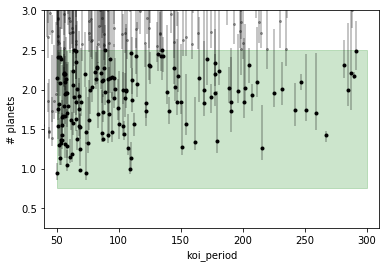

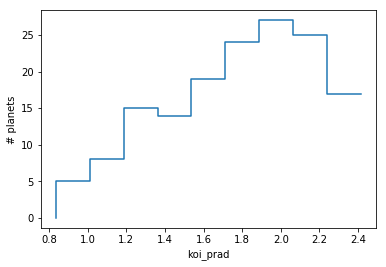

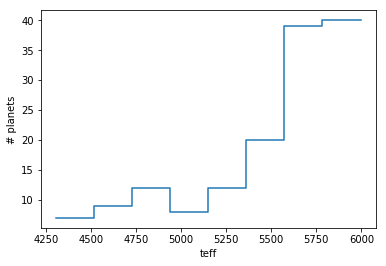

In [80]:
cdpp_cols = [k for k in stlr.keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)

# Pre-compute and freeze the gamma function from Equation (5) in
# Burke et al.
pgam = gamma(4.65, loc=0., scale=0.98)
mesthres_cols = [k for k in stlr.keys() if k.startswith("mesthres")]
mesthres_vals = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],
                         dtype=float)

# Lines to change for different stellar parameters.
#var_names = ["koi_period", "koi_prad", "rrmscdpp06p0"]
var_names = ["koi_period", "koi_prad", "teff"]
#c_rng = (min(stlr.rrmscdpp06p0.values), 750)  # CDPP
c_rng = (4200, 6101)  # Teff

period_rng = (50, 300)
rp_rng = (0.75, 2.5)

ranges = [period_rng, rp_rng, c_rng]
stlr, kois = selection(stlr, ranges)

nbins = [9, 11, 10]
bins = plot_obs_and_get_bin_edges(var_names, nbins, ranges)

In [81]:
grid_points_per_bin = 2
print(c_grid[0, 0, :])

[ 4200.          4411.11111111  4622.22222222  4833.33333333  5044.44444444
  5255.55555556  5466.66666667  5677.77777778  5888.88888889  6100.        ]


In [147]:
comp, period_grid, rp_grid, c_grid = calc_completeness_for_each_star(ranges, nbins*grid_points_per_bin, "teff")

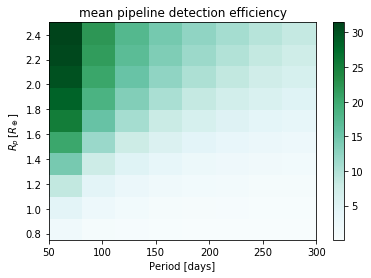

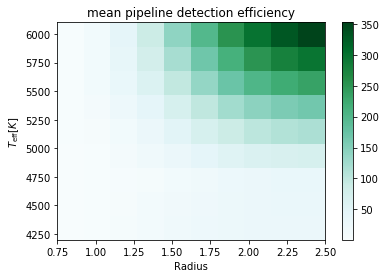

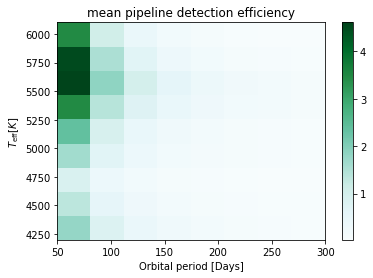

In [145]:
grid = [period_grid, rp_grid, c_grid]
plot_det_eff_3d(grid, comp, "$T_{\mathrm{eff}}[K]$")